---------------------------------------------------
# CEWA 568 Snow Hydrology
## Homework #8: *Energy and Mass Balance: What makes snow melt!* 
All good things, like this class and the seasonal snowpack, have to come to an end. With this final module, we will investigate how all of our snow melts away, and how sublimation changes to evaporation and melt.
#### Notebook Author: Cassie Lumbrazo

---------------------------------------------------

In [1]:
#first import the relevant python packages
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib 
import matplotlib.pyplot as plt

import json
import pytz

import seaborn as sns 

sns.set_theme()
plt.rcParams['figure.figsize'] = [12,6] #overriding size

---

# Homework 8
## Problem 1: Energy for melt and melt rates
Using the data collected, as presented in Lab 8-1, calculate 

**a) the total daily energy balance,** 
* calculating all the components of the energy balance

**b) the total daily change in snow temperature,** 
* snow temperature at the end of the day, minus the start of the day

**c) the total daily vertical water vapor flux, and**  
* LH W/m2 converted to mm/day 

**d) the total daily snow melt for the period from April 1 to April 21, and then, separately from April 25 to May 10.**  

* Do our data suggest that the mass and energy budgets work? 
* If not, what do you think are the primary sources of our errors? 

*Note: There was a power surge on May 11 that created incorrect flux numbers and broke the radiomter, so we will leave processing that data until some other time.*

---

In [2]:
ds_og = xr.open_dataset('sos_EB_1Apr_15May2023.nc')

In [3]:
# everything is in UTC. I do not want to be making energy balance calculations without knowing the real time. 
# Lets do UTC - 7 

ds = ds_og.shift(time=-7)

(19448.0, 19449.0)

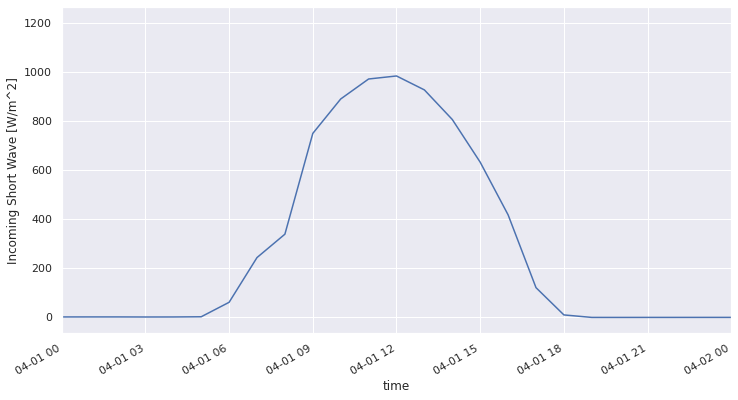

In [4]:
ds.Rsw_in_9m_d.plot()
plt.xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,2))

now we can sum over the normal day hours for radiation and energy balance calculations

In [5]:
# Define constants
Lh_sub = 2835
# above we define latent heat of sublimation in J/g

cpair = 1005.7
# above is specific heat at constant pressure for dry air in J/kg/K as reported by the Glossary of Meteorology

### Calculate the total energy balance each hour

The total energy balance at the snow suface is

$$
c_p^{SS} \frac{\delta T_{SS}}{\delta t} + \lambda \frac{\delta T_{S}}{\delta z} + E_{melt} = LW_{in} - LW_{out} + SW_{in} - SW_{out} - LH - SH + G 
$$

where the left hand side represents changes to the snowpack, through warming the surface temperature $c_p^{SS} \frac{\delta T_{SS}}{\delta t}$, conducting heat into lower layers of the snowpack $\lambda \frac{\delta T_{S}}{\delta z}$, or melting the snow $E_{melt}$.  

This is balanced by the heat exchange at the surface $LW_{in} - LW_{out} + SW_{in} - SW_{out} - LH - SH$ and the ground heat flux $G$.  

We need to be very careful with the signs and units of all of these terms, as we will see below.

In [6]:
# net radiation
ds['Rad_net'] = ds['Rsw_in_9m_d'] + ds['LWin'] - ds['Rsw_out_9m_d'] - ds['LWout']

# turbulent fluxes, converted to W/m^2 affecting the snowpack
ds['LH_flux'] = (-Lh_sub * ds['w_h2o__3m_c'])          #label='3 m LH flux (W/m^2)')
ds['SH_flux'] = (-cpair * ds['ro'] * ds['w_tc__3m_c']) #label='3 m SH flux (W/m^2)')

# sum of the turbulent fluxes, converted to W/m^2 affecting the snowpack
ds['LH_SH_sum'] = ds['SH_flux'] + ds['LH_flux'] #label='sum turbulent flux (W/m^2)')

# Now, the cumulative energy sum is putting together the net radiation and the LH+SH sum
ds['Energy_sum'] = ds['Rad_net'] + ds['LH_SH_sum']

ds_1D = ds.copy(deep=True)
ds_1D = ds_1D.resample(time='1D').sum()

ds['Energy_cumulative_sum'] = np.cumsum(ds['Energy_sum'])
ds_1D['Energy_cumulative_sum'] = np.cumsum(ds_1D['Energy_sum'])

In [7]:
# We want to make sure my calculations match Jessica's from Lab8-1
# cumulative energy sum
cumulative_energy_sum = np.cumsum(ds['Rsw_in_9m_d'] + ds['LWin'] - ds['Rsw_out_9m_d'] - ds['LWout']
                                  -cpair *  ds['ro'] * ds['w_tc__3m_c'] - Lh_sub * ds['w_h2o__3m_c'])

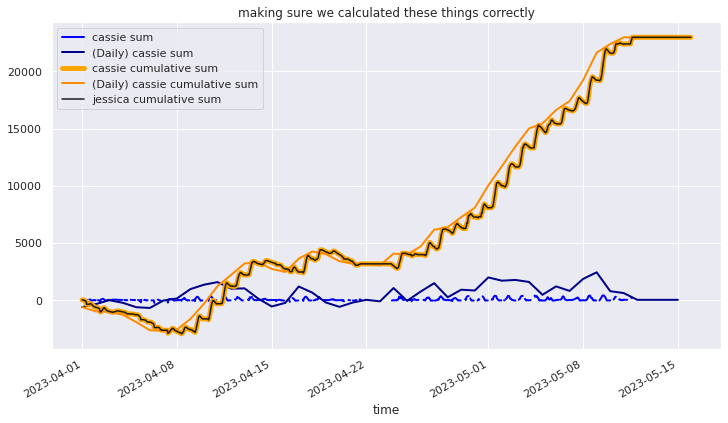

In [8]:
ds['Energy_sum'].plot(label='cassie sum', linewidth=2, color='blue')
ds_1D['Energy_sum'].plot(label='(Daily) cassie sum', linewidth=2, color='darkblue')
ds['Energy_cumulative_sum'].plot(label='cassie cumulative sum', linewidth=5, color='orange')
ds_1D['Energy_cumulative_sum'].plot(label='(Daily) cassie cumulative sum', linewidth=2, color='darkorange')

cumulative_energy_sum.plot(label='jessica cumulative sum', color='k')
plt.title('making sure we calculated these things correctly')
plt.legend()

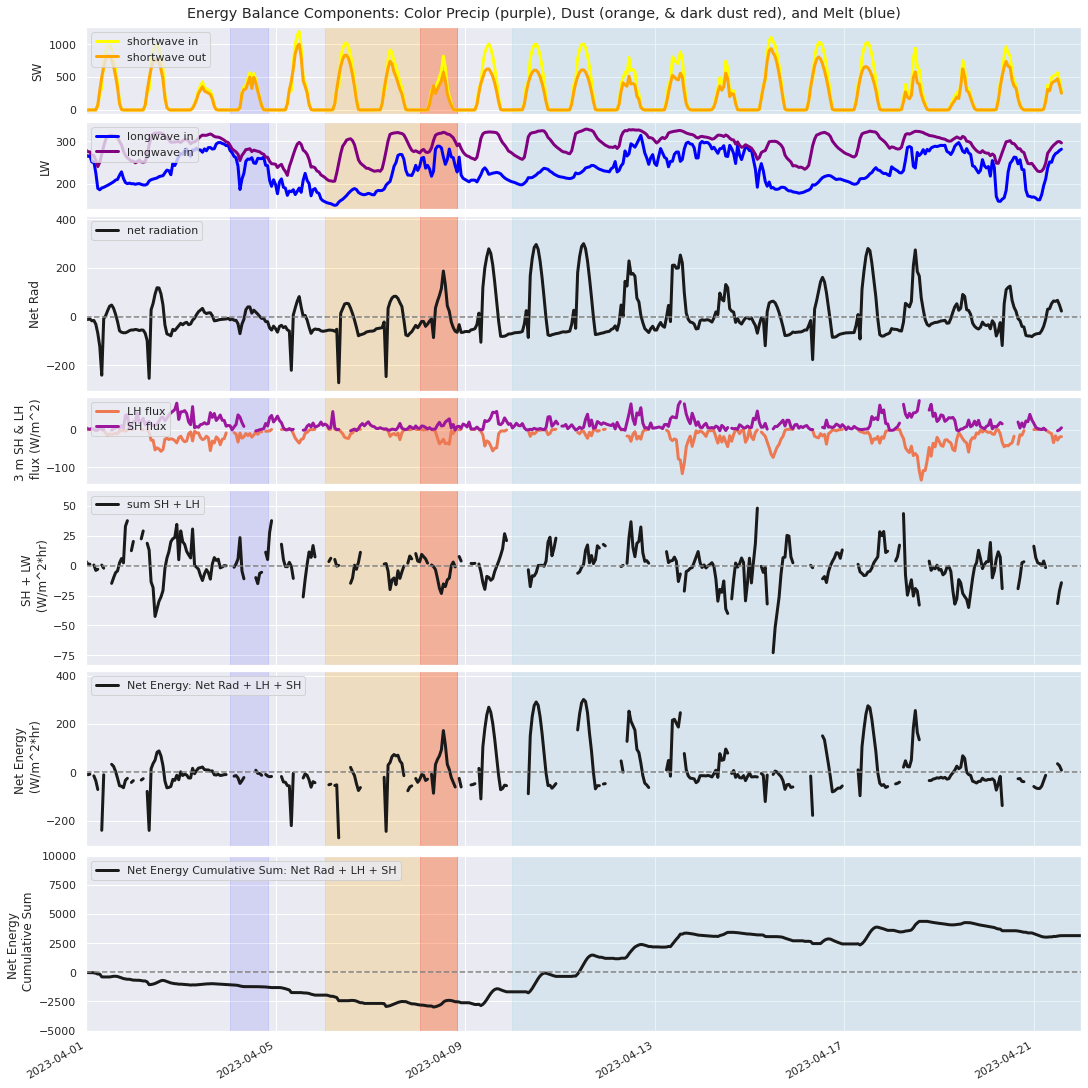

In [9]:
fig, axes = plt.subplots(7, 1, figsize=(15,15), sharex=True, constrained_layout = True,
                         gridspec_kw={'height_ratios': [1, 1, 2, 1, 2, 2, 2]})

plt.suptitle('Energy Balance Components: Color Precip (purple), Dust (orange, & dark dust red), and Melt (blue)')

width = 3 # set most of the line widths here for visualization 
colors1 = plt.cm.plasma(np.linspace(0, 1, 13))
colors2 = plt.cm.viridis(np.linspace(0, 1, 6))

# shortwave
ds['Rsw_in_9m_d'].plot(ax=axes[0], label='shortwave in', linewidth = width, color='yellow')
ds['Rsw_out_9m_d'].plot(ax=axes[0], label='shortwave out', linewidth = width, color='orange')
axes[0].set_ylabel("SW")

# longwave
ds['LWin'].plot(ax=axes[1], label='longwave in', linewidth = width, color='blue')
ds['LWout'].plot(ax=axes[1], label='longwave in', linewidth = width, color='purple')
axes[1].set_ylabel("LW")

# net radiation
ds['Rad_net'].plot(ax=axes[2], label='net radiation', linewidth = width, color='k')
axes[2].set_ylabel("Net Rad")
axes[2].axhline(y = 0, color = 'grey', linestyle = '--')


# ___________________________________________________________________________________________

# sensible and latent heat flux
ds['LH_flux'].plot(ax=axes[3], label='LH flux', linewidth = width, color=colors1[8])
ds['SH_flux'].plot(ax=axes[3], label='SH flux', linewidth = width, color=colors1[4])
axes[3].set_ylabel("3 m SH & LH \n flux (W/m^2)")

# net flux 
ds['LH_SH_sum'].plot(ax=axes[4], label='sum SH + LH', linewidth = width, color='k')
axes[4].set_ylabel("SH + LW \n (W/m^2*hr)")
axes[4].axhline(y = 0, color = 'grey', linestyle = '--')

# sum energy 
ds['Energy_sum'].plot(ax=axes[5], label='Net Energy: Net Rad + LH + SH', linewidth=width, color='k')
axes[5].set_ylabel("Net Energy \n (W/m^2*hr)")
axes[5].axhline(y = 0, color = 'grey', linestyle = '--')

# cumulative energy 
ds['Energy_cumulative_sum'].plot(ax=axes[6], label='Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='k')
axes[6].set_ylim([-5000, 10000])
axes[6].set_ylabel("Net Energy \n Cumulative Sum")
axes[6].axhline(y = 0, color = 'grey', linestyle = '--')

# # Jessica's plot of cumulative energy sum
# cumulative_energy_sum.plot(ax=axes[6], label='net energy', linewidth=width, color=colors1[0])
# axes[6].set_ylabel("Cumulative sum, \n Combined flux (W/m^2*hr)")

# shade events
for ax in axes:
    ax.axvspan(dt.datetime(2023,4,4,1), dt.datetime(2023,4,4,20), alpha=0.1, color='blue')     #snowfall event
    ax.axvspan(dt.datetime(2023,4,6,1), dt.datetime(2023,4,8,20), alpha=0.2, color='orange')   #dust comes
    ax.axvspan(dt.datetime(2023,4,8,1), dt.datetime(2023,4,8,20), alpha=0.2, color='red')      #dark dust (says notes)
    ax.axvspan(dt.datetime(2023,4,10), dt.datetime(2023,4,30), alpha=0.3, color='lightblue')  #melt unset 

    
# legends et al. 
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[3].legend(loc='upper left')
axes[4].legend(loc='upper left')
axes[5].legend(loc='upper left')
axes[6].legend(loc='upper left')

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
axes[3].set_xlabel("")
axes[4].set_xlabel("")
axes[5].set_xlabel("")
axes[6].set_xlabel("")

# axes[1].set_ylabel("Snow temperature,\ndegrees [C]")

axes[0].set_xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,22))
plt.show()

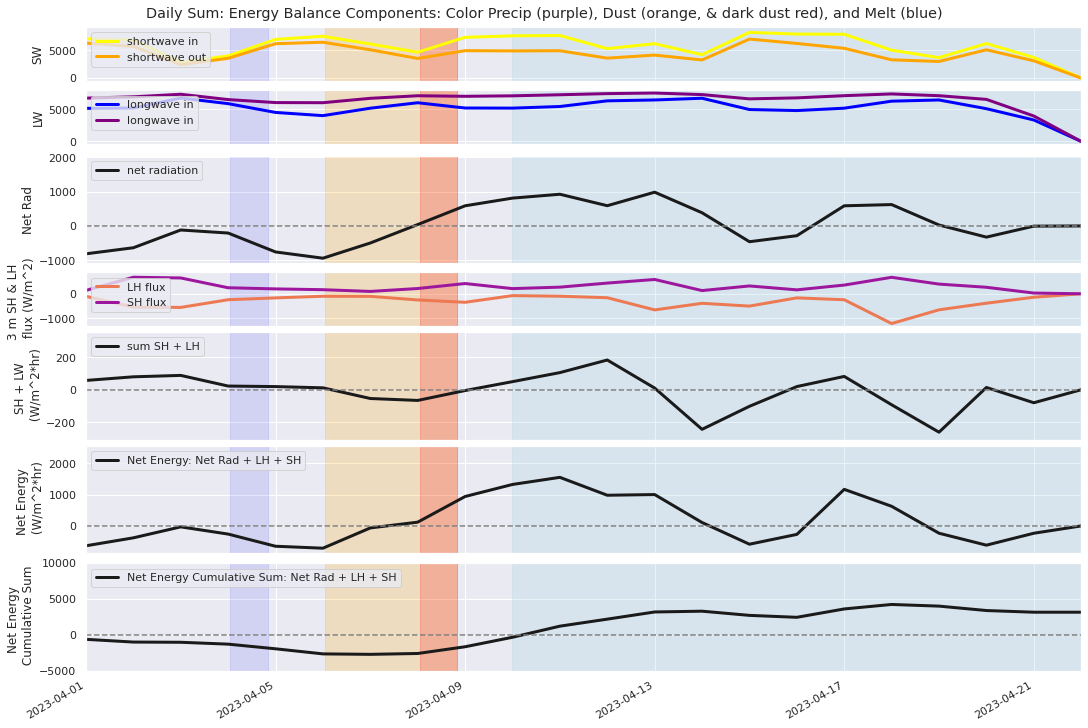

In [10]:
fig, axes = plt.subplots(7, 1, figsize=(15,10), sharex=True, constrained_layout = True,
                         gridspec_kw={'height_ratios': [1, 1, 2, 1, 2, 2, 2]})

plt.suptitle('Daily Sum: Energy Balance Components: Color Precip (purple), Dust (orange, & dark dust red), and Melt (blue)')

width = 3 # set most of the line widths here for visualization 
colors1 = plt.cm.plasma(np.linspace(0, 1, 13))
colors2 = plt.cm.viridis(np.linspace(0, 1, 6))

# shortwave
ds_1D['Rsw_in_9m_d'].plot(ax=axes[0], label='shortwave in', linewidth = width, color='yellow')
ds_1D['Rsw_out_9m_d'].plot(ax=axes[0], label='shortwave out', linewidth = width, color='orange')
axes[0].set_ylabel("SW")

# longwave
ds_1D['LWin'].plot(ax=axes[1], label='longwave in', linewidth = width, color='blue')
ds_1D['LWout'].plot(ax=axes[1], label='longwave in', linewidth = width, color='purple')
axes[1].set_ylabel("LW")

# net radiation
ds_1D['Rad_net'].plot(ax=axes[2], label='net radiation', linewidth = width, color='k')
axes[2].set_ylabel("Net Rad")
axes[2].axhline(y = 0, color = 'grey', linestyle = '--')


# ___________________________________________________________________________________________

# sensible and latent heat flux
ds_1D['LH_flux'].plot(ax=axes[3], label='LH flux', linewidth = width, color=colors1[8])
ds_1D['SH_flux'].plot(ax=axes[3], label='SH flux', linewidth = width, color=colors1[4])
axes[3].set_ylabel("3 m SH & LH \n flux (W/m^2)")

# net flux 
ds_1D['LH_SH_sum'].plot(ax=axes[4], label='sum SH + LH', linewidth = width, color='k')
axes[4].set_ylabel("SH + LW \n (W/m^2*hr)")
axes[4].axhline(y = 0, color = 'grey', linestyle = '--')

# sum energy 
ds_1D['Energy_sum'].plot(ax=axes[5], label='Net Energy: Net Rad + LH + SH', linewidth=width, color='k')
axes[5].set_ylabel("Net Energy \n (W/m^2*hr)")
axes[5].axhline(y = 0, color = 'grey', linestyle = '--')

# cumulative energy 
ds_1D['Energy_cumulative_sum'].plot(ax=axes[6], label='Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='k')
axes[6].set_ylim([-5000, 10000])
axes[6].set_ylabel("Net Energy \n Cumulative Sum")
axes[6].axhline(y = 0, color = 'grey', linestyle = '--')

# # Jessica's plot of cumulative energy sum
# cumulative_energy_sum.plot(ax=axes[6], label='net energy', linewidth=width, color=colors1[0])
# axes[6].set_ylabel("Cumulative sum, \n Combined flux (W/m^2*hr)")

# shade events
for ax in axes:
    ax.axvspan(dt.datetime(2023,4,4,1), dt.datetime(2023,4,4,20), alpha=0.1, color='blue')     #snowfall event
    ax.axvspan(dt.datetime(2023,4,6,1), dt.datetime(2023,4,8,20), alpha=0.2, color='orange')   #dust comes
    ax.axvspan(dt.datetime(2023,4,8,1), dt.datetime(2023,4,8,20), alpha=0.2, color='red')      #dark dust (says notes)
    ax.axvspan(dt.datetime(2023,4,10), dt.datetime(2023,4,30), alpha=0.3, color='lightblue')  #melt unset 

    
# legends et al. 
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[3].legend(loc='upper left')
axes[4].legend(loc='upper left')
axes[5].legend(loc='upper left')
axes[6].legend(loc='upper left')

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
axes[3].set_xlabel("")
axes[4].set_xlabel("")
axes[5].set_xlabel("")
axes[6].set_xlabel("")

axes[0].set_xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,22))
plt.show()

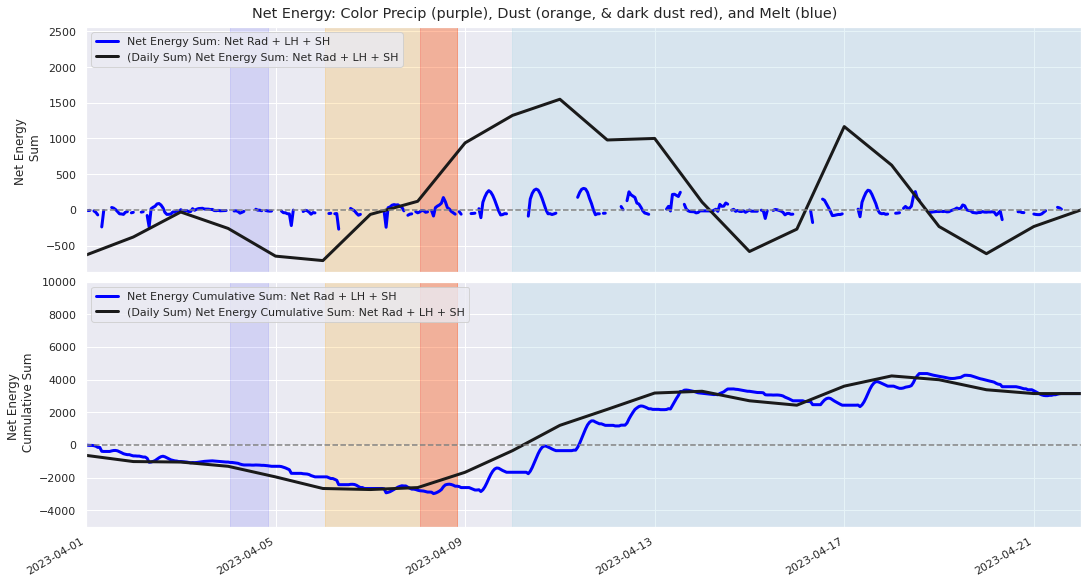

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(15,8), sharex=True, constrained_layout = True, gridspec_kw={'height_ratios': [1,1]})

plt.suptitle('Net Energy: Color Precip (purple), Dust (orange, & dark dust red), and Melt (blue)')

# sum energy 
ds['Energy_sum'].plot(ax=axes[0], label='Net Energy Sum: Net Rad + LH + SH', linewidth=width, color='blue')
ds_1D['Energy_sum'].plot(ax=axes[0], label='(Daily Sum) Net Energy Sum: Net Rad + LH + SH', linewidth=width, color='k')

# axes[0].set_ylim([-100000, 100000])
axes[0].set_ylabel("Net Energy \n Sum")
axes[0].axhline(y = 0, color = 'grey', linestyle = '--')

# cumulative sum energy 
ds['Energy_cumulative_sum'].plot(ax=axes[1], label='Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='blue')
ds_1D['Energy_cumulative_sum'].plot(ax=axes[1], label='(Daily Sum) Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='k')
axes[1].set_ylim([-5000, 10000])
axes[1].set_ylabel("Net Energy \n Cumulative Sum")
axes[1].axhline(y = 0, color = 'grey', linestyle = '--')

# shade events
for ax in axes:
    ax.axvspan(dt.datetime(2023,4,4,1), dt.datetime(2023,4,4,20), alpha=0.1, color='blue')     #snowfall event
    ax.axvspan(dt.datetime(2023,4,6,1), dt.datetime(2023,4,8,20), alpha=0.2, color='orange')   #dust comes
    ax.axvspan(dt.datetime(2023,4,8,1), dt.datetime(2023,4,8,20), alpha=0.2, color='red')      #dark dust (says notes)
    ax.axvspan(dt.datetime(2023,4,10), dt.datetime(2023,4,30), alpha=0.3, color='lightblue')  #melt unset 

# legends et al. 
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

axes[0].set_xlabel("")
axes[1].set_xlabel("")

axes[0].set_xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,22))
plt.show()

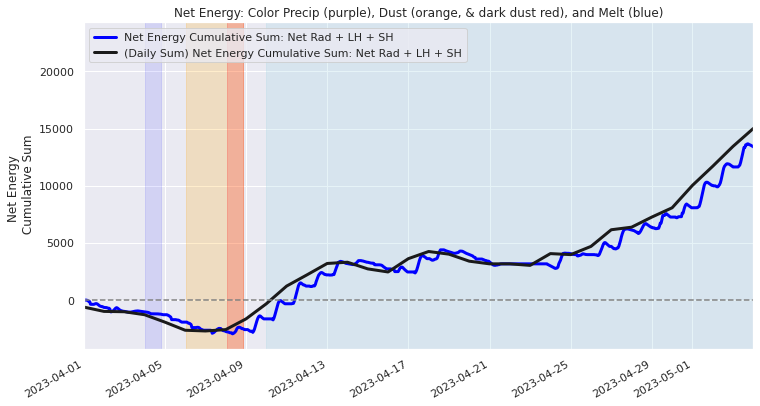

In [12]:
# cumulative sum energy 
ds['Energy_cumulative_sum'].plot(label='Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='blue')
ds_1D['Energy_cumulative_sum'].plot(label='(Daily Sum) Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='k')
# plt.ylim([-5000, 10000])
plt.ylabel("Net Energy \n Cumulative Sum")
plt.axhline(y = 0, color = 'grey', linestyle = '--')

# plotting events
plt.axvspan(dt.datetime(2023,4,4,1), dt.datetime(2023,4,4,20), alpha=0.1, color='blue')     #snowfall event
plt.axvspan(dt.datetime(2023,4,6,1), dt.datetime(2023,4,8,20), alpha=0.2, color='orange')   #dust comes
plt.axvspan(dt.datetime(2023,4,8,1), dt.datetime(2023,4,8,20), alpha=0.2, color='red')      #dark dust (says notes)
plt.axvspan(dt.datetime(2023,4,10), dt.datetime(2023,5,4), alpha=0.3, color='lightblue')  #melt unset 

# legends et al. 
plt.title('Net Energy: Color Precip (purple), Dust (orange, & dark dust red), and Melt (blue)')
plt.legend(loc='upper left')
plt.xlabel("")
plt.xlim(dt.datetime(2023,4,1), dt.datetime(2023,5,4))
plt.show()

--- 
### Problem 1: Part A Solution. 
**a) the total daily energy balance,** 
* completed above by calculating all the components of the energy balance
* we can see the total daily energy balance dramatically change once melt turns on (in blue) 
* there is also a decrease when there is dust on snow (orange and red), which is interesting
---

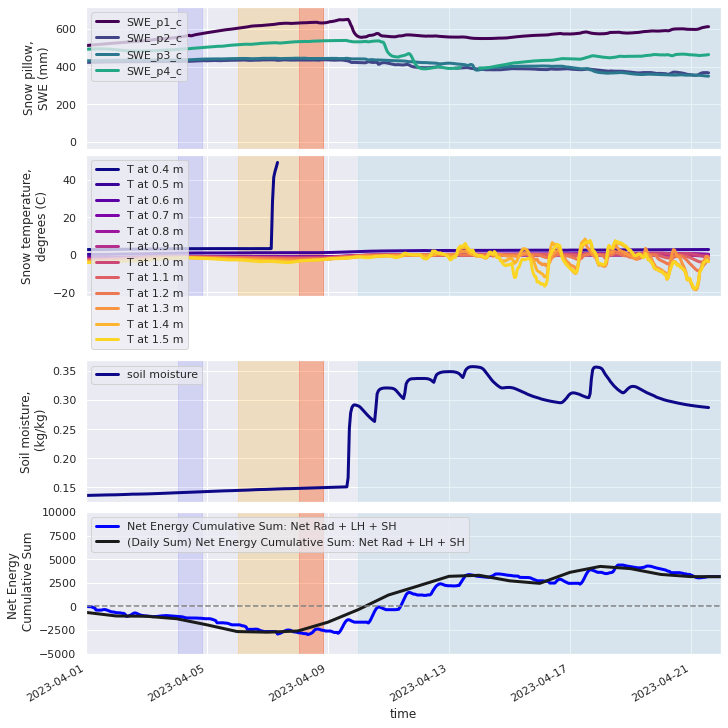

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(10,10), sharex=True, constrained_layout = True) #gridspec_kw={'height_ratios': [2, 2, 2, 2, 2, 2]}

width = 3 # set most of the line widths here for visualization 
colors1 = plt.cm.plasma(np.linspace(0, 1, 13))
colors2 = plt.cm.viridis(np.linspace(0, 1, 6))

ds['SWE_p1_c'].plot(ax=axes[0], label='SWE_p1_c', linewidth = width, color=colors2[0])
ds['SWE_p2_c'].plot(ax=axes[0], label='SWE_p2_c', linewidth = width, color=colors2[1])
ds['SWE_p3_c'].plot(ax=axes[0], label='SWE_p3_c', linewidth = width, color=colors2[2])
ds['SWE_p4_c'].plot(ax=axes[0], label='SWE_p4_c', linewidth = width, color=colors2[3])

ds['Tsnow_0_4m_d'].plot(ax=axes[1], label='T at 0.4 m', linewidth = width, color=colors1[0])
ds['Tsnow_0_5m_d'].plot(ax=axes[1], label='T at 0.5 m', linewidth = width, color=colors1[1])
ds['Tsnow_0_6m_d'].plot(ax=axes[1], label='T at 0.6 m', linewidth = width, color=colors1[2])
ds['Tsnow_0_7m_d'].plot(ax=axes[1], label='T at 0.7 m', linewidth = width, color=colors1[3])
ds['Tsnow_0_8m_d'].plot(ax=axes[1], label='T at 0.8 m', linewidth = width, color=colors1[4])
ds['Tsnow_0_9m_d'].plot(ax=axes[1], label='T at 0.9 m', linewidth = width, color=colors1[5])
ds['Tsnow_1_0m_d'].plot(ax=axes[1], label='T at 1.0 m', linewidth = width, color=colors1[6])
ds['Tsnow_1_1m_d'].plot(ax=axes[1], label='T at 1.1 m', linewidth = width, color=colors1[7])
ds['Tsnow_1_2m_d'].plot(ax=axes[1], label='T at 1.2 m', linewidth = width, color=colors1[8])
ds['Tsnow_1_3m_d'].plot(ax=axes[1], label='T at 1.3 m', linewidth = width, color=colors1[9])
ds['Tsnow_1_4m_d'].plot(ax=axes[1], label='T at 1.4 m', linewidth = width, color=colors1[10])
ds['Tsnow_1_5m_d'].plot(ax=axes[1], label='T at 1.5 m', linewidth = width, color=colors1[11])

# soil moisture
ds['Qsoil_d'].plot(ax=axes[2], label='soil moisture', linewidth = width, color=colors1[0])

# cumulative sum energy 
ds['Energy_cumulative_sum'].plot(ax=axes[3], label='Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='blue')
ds_1D['Energy_cumulative_sum'].plot(ax=axes[3], label='(Daily Sum) Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='k')
axes[3].set_ylim([-5000, 10000])
axes[3].set_ylabel("Net Energy \n Cumulative Sum")
axes[3].axhline(y = 0, color = 'grey', linestyle = '--')

# shade events
for ax in axes:
    ax.axvspan(dt.datetime(2023,4,4,1), dt.datetime(2023,4,4,20), alpha=0.1, color='blue')     #snowfall event
    ax.axvspan(dt.datetime(2023,4,6,1), dt.datetime(2023,4,8,20), alpha=0.2, color='orange')   #dust comes
    ax.axvspan(dt.datetime(2023,4,8,1), dt.datetime(2023,4,8,20), alpha=0.2, color='red')      #dark dust (says notes)
    ax.axvspan(dt.datetime(2023,4,10), dt.datetime(2023,4,30), alpha=0.3, color='lightblue')  #melt unset 
    
# legends et al. 
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[3].legend(loc='upper left')

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Snow pillow,\nSWE (mm)")
axes[1].set_ylabel("Snow temperature,\ndegrees (C)")
axes[2].set_ylabel("Soil moisture,\n (kg/kg)")
# axes[3].set_ylabel("Cumulative sum, \n Combined flux (W/m^2*hr)")

axes[0].set_xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,22))
plt.show()

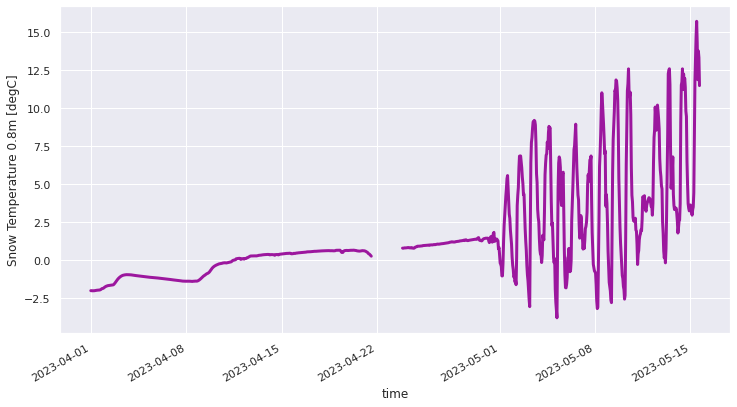

In [14]:
# Picking one of the temperature censors to pick for calculating the total daily change in snow temperature 
ds['Tsnow_0_8m_d'].plot(label='T at 0.8 m', linewidth = width, color=colors1[4])

(19448.5, 19450.0)

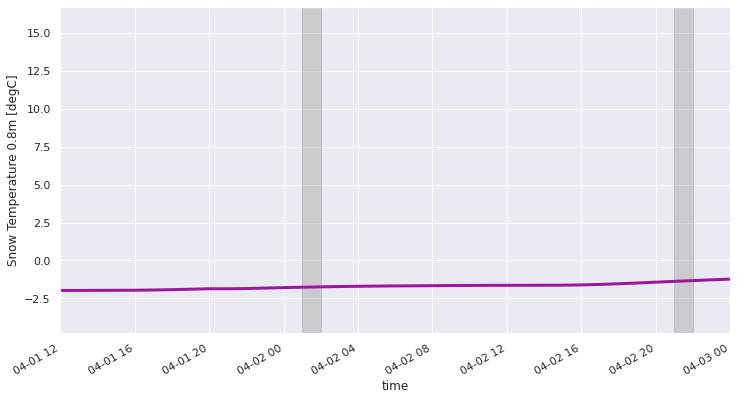

In [15]:
# Picking one of the temperature censors to pick for calculating the total daily change in snow temperature 
ds['Tsnow_0_8m_d'].plot(label='T at 0.8 m', linewidth = width, color=colors1[4])

plt.axvspan(dt.datetime(2023,4,2,1), dt.datetime(2023,4,2,2), alpha=0.3, color='grey') #"start" temp here for the day 
plt.axvspan(dt.datetime(2023,4,2,21), dt.datetime(2023,4,2,22), alpha=0.3, color='grey') #example of where we are saying the start  


plt.xlim(dt.datetime(2023,4,1,12), dt.datetime(2023,4,3,))

In [16]:
# The change should be pretty small, at least, before melting. The snowpack is nearly isothermal. 
# ds['Tsnow_0_8m_d'] #using this temperature
# ds.sel(time='2023-04-10') #can select time like this.. but we want the first and late time of everyday

# ds_first = ds.resample(time='1D', origin='start_day')
# ds_last = ds.resample(time='1D',  origin='end_day')

# ds.resample
# Trying to figure out how to sample the dataset for the hours.. I forget the code for this. 

In [17]:
ds_first = ds.isel(time=(ds.time.dt.hour ==  1)) #FINALLY found the line of code I needed for this: https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations
ds_last  = ds.isel(time=(ds.time.dt.hour == 23))

In [18]:
tfirst = ds_first['Tsnow_0_8m_d'].values.flatten()
tlast = ds_last['Tsnow_0_8m_d'].values.flatten()

tdiff = tlast - tfirst

In [19]:
df = pd.DataFrame()
df['daily_dates'] = pd.date_range(start='4/1/2023', end='5/15/2023') 
df['tdiff'] = tdiff

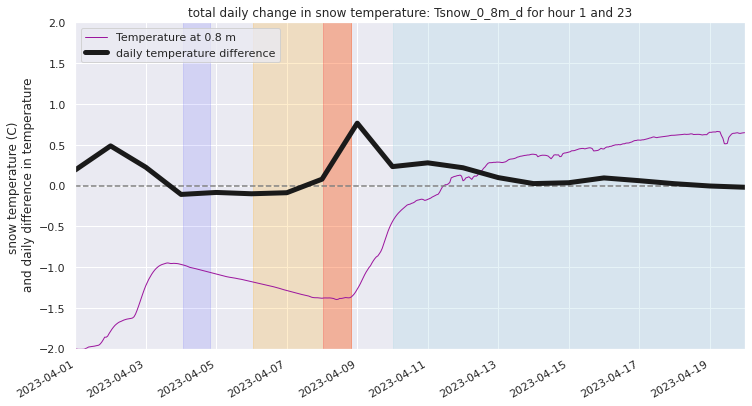

In [20]:

# Picking one of the temperature censors to pick for calculating the total daily change in snow temperature 
ds['Tsnow_0_8m_d'].plot(label='Temperature at 0.8 m', linewidth = 1, color=colors1[4])
plt.axhline(y = 0, color = 'grey', linestyle = '--')

plt.plot(df['daily_dates'],df['tdiff'], label='daily temperature difference', linewidth=5, color='k')


plt.title('total daily change in snow temperature: Tsnow_0_8m_d for hour 1 and 23')

# plotting events
plt.axvspan(dt.datetime(2023,4,4,1), dt.datetime(2023,4,4,20), alpha=0.1, color='blue')     #snowfall event
plt.axvspan(dt.datetime(2023,4,6,1), dt.datetime(2023,4,8,20), alpha=0.2, color='orange')   #dust comes
plt.axvspan(dt.datetime(2023,4,8,1), dt.datetime(2023,4,8,20), alpha=0.2, color='red')      #dark dust (says notes)
plt.axvspan(dt.datetime(2023,4,10), dt.datetime(2023,5,4), alpha=0.3, color='lightblue')  #melt unset 

plt.xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,20))
plt.ylim([-2, 2])

plt.ylabel("snow temperature (C) \n and daily difference in temperature")
plt.xlabel("")
plt.legend(loc='upper left')
plt.show()

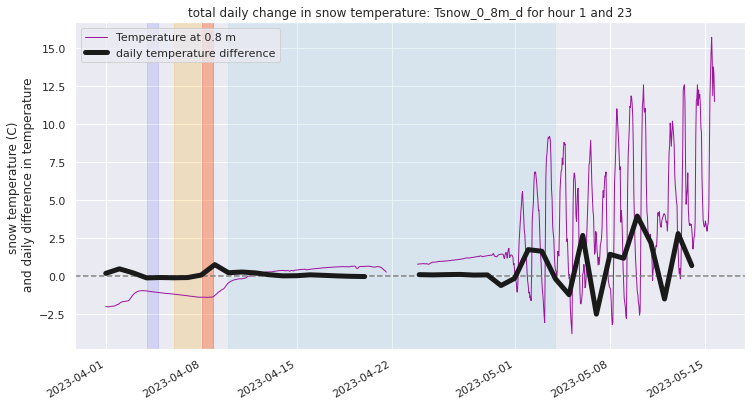

In [21]:

# Picking one of the temperature censors to pick for calculating the total daily change in snow temperature 
ds['Tsnow_0_8m_d'].plot(label='Temperature at 0.8 m', linewidth = 1, color=colors1[4])
plt.axhline(y = 0, color = 'grey', linestyle = '--')

plt.plot(df['daily_dates'],df['tdiff'], label='daily temperature difference', linewidth=5, color='k')


plt.title('total daily change in snow temperature: Tsnow_0_8m_d for hour 1 and 23')

# plotting events
plt.axvspan(dt.datetime(2023,4,4,1), dt.datetime(2023,4,4,20), alpha=0.1, color='blue')     #snowfall event
plt.axvspan(dt.datetime(2023,4,6,1), dt.datetime(2023,4,8,20), alpha=0.2, color='orange')   #dust comes
plt.axvspan(dt.datetime(2023,4,8,1), dt.datetime(2023,4,8,20), alpha=0.2, color='red')      #dark dust (says notes)
plt.axvspan(dt.datetime(2023,4,10), dt.datetime(2023,5,4), alpha=0.3, color='lightblue')   #melt unset 

plt.ylabel("snow temperature (C) \n and daily difference in temperature")
plt.xlabel("")
plt.legend(loc='upper left')
plt.show()

--- 
### Problem 1: Part B Solution. 
**b) the total daily change in snow temperature,** 
* snow temperature at the end of the day, minus the start of the day
* from the plot above, we can see that that the snowpack had very small differences in daily snow temperature before the melt started. This spiked a bit when there was dust on snow. 
* once melting began, the snowpack was isothermal and there wasn't a daily change in temperature (i.e., diff = 0) 
* then, once all the snow melted at the height I plotted, the temperature starts to follow air temperature 
---

Text(0, 0.5, 'LH flux in W/m2')

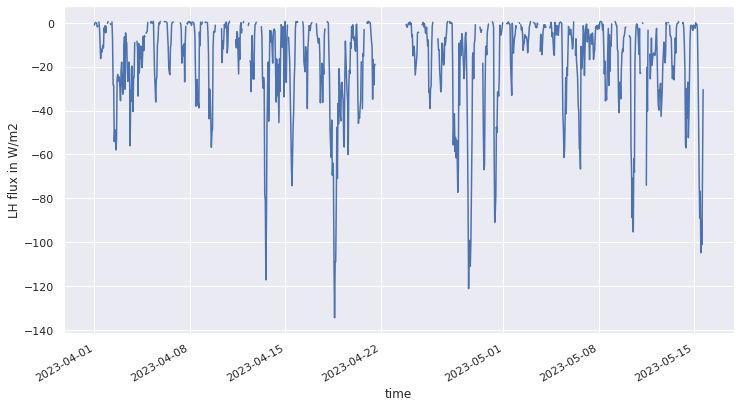

In [22]:
ds.LH_flux.plot()
plt.ylabel('LH flux in W/m2')

*okay, we want to conver LH flux in W/m2 to an amount of liquid water vapor in mm/day*

In [23]:
ds['LH_as_water_vapor'] = ds['LH_flux'] * -1 * 3600 * 24 / 2256 / 1000 / 1000 * 1000 # similar calculation as the one below (see photo) except with the latent heat of vaporization

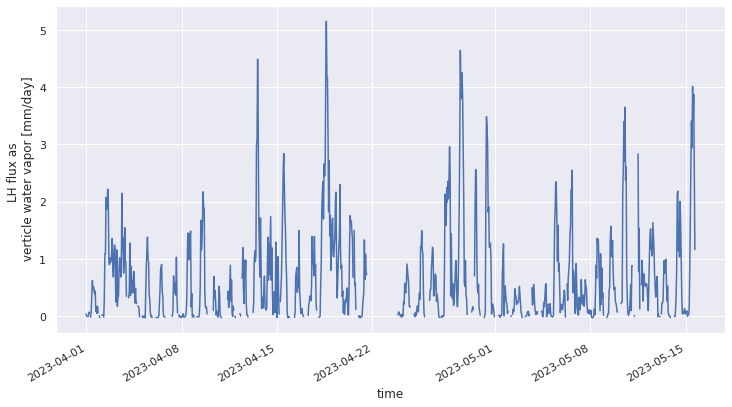

In [24]:
ds['LH_as_water_vapor'].plot()
plt.ylabel('LH flux as \n verticle water vapor [mm/day]')
plt.show()

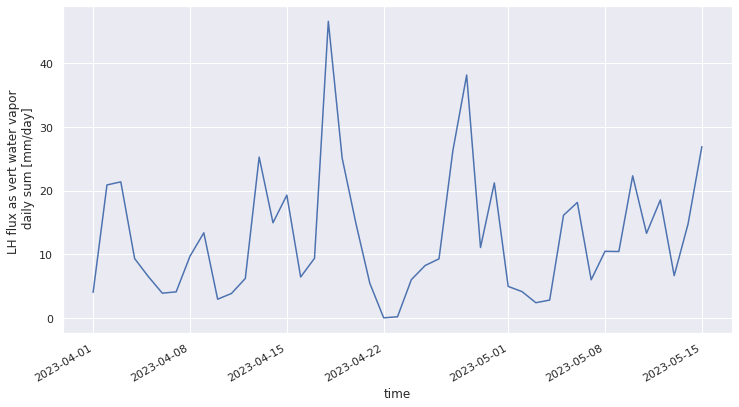

In [25]:
# ds['LH_as_water_vapor_dailysum'] = ds['LH_as_water_vapor'].resample(time='1D').sum()
(ds['LH_as_water_vapor'].resample(time='1D').sum()).plot()

plt.ylabel('LH flux as vert water vapor \n daily sum [mm/day]')
plt.show()

In [26]:
(ds['LH_as_water_vapor'].resample(time='1D').sum()).mean()

<xarray.DataArray 'LH_as_water_vapor' ()>
array(12.696935, dtype=float32)

--- 
### Problem 1: Part C Solution. 
**c) the total daily vertical water vapor flux, and**  
* LH W/m2 converted to mm/day in the plot above 
* With a daily average around 12 mm of water vapor flux.
---

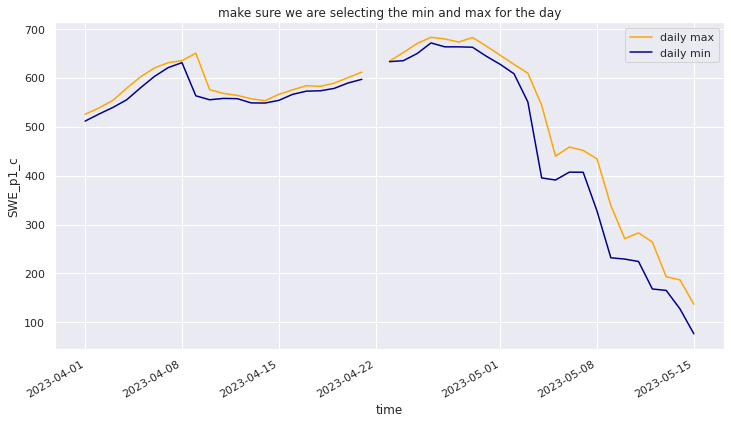

In [27]:
(ds.SWE_p1_c.resample(time='1D').max()).plot(label='daily max', color='orange')
(ds.SWE_p1_c.resample(time='1D').min()).plot(label='daily min', color='darkblue')

plt.title('make sure we are selecting the min and max for the day')
plt.legend()
plt.show()

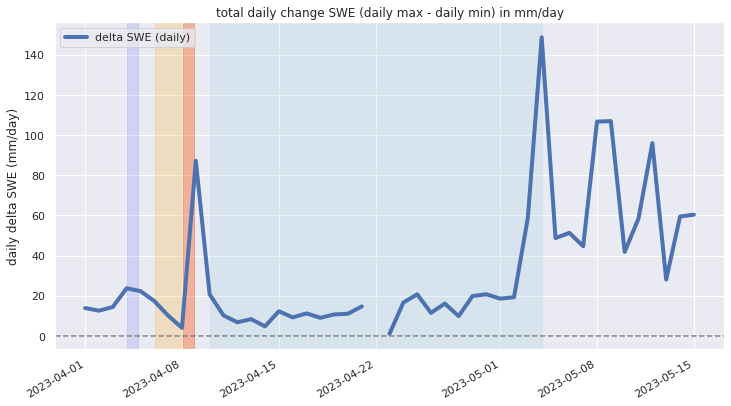

In [28]:
(ds.SWE_p1_c.resample(time='1D').max() - ds.SWE_p1_c.resample(time='1D').min()).plot(linewidth=4, label='delta SWE (daily)')

plt.title('total daily change SWE (daily max - daily min) in mm/day')
plt.axhline(y = 0, color = 'grey', linestyle = '--')

# plotting events
plt.axvspan(dt.datetime(2023,4,4,1), dt.datetime(2023,4,4,20), alpha=0.1, color='blue')     #snowfall event
plt.axvspan(dt.datetime(2023,4,6,1), dt.datetime(2023,4,8,20), alpha=0.2, color='orange')   #dust comes
plt.axvspan(dt.datetime(2023,4,8,1), dt.datetime(2023,4,8,20), alpha=0.2, color='red')      #dark dust (says notes)
plt.axvspan(dt.datetime(2023,4,10), dt.datetime(2023,5,4), alpha=0.3, color='lightblue')   #melt unset 

plt.ylabel("daily delta SWE (mm/day)")
plt.xlabel("")
plt.legend(loc='upper left')
plt.show()

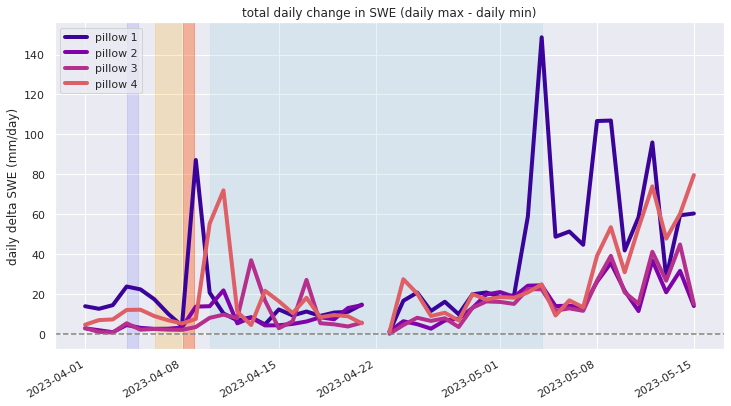

In [29]:
(ds.SWE_p1_c.resample(time='1D').max() - ds.SWE_p1_c.resample(time='1D').min()).plot(linewidth=4, label='pillow 1', color=colors1[1])
(ds.SWE_p2_c.resample(time='1D').max() - ds.SWE_p2_c.resample(time='1D').min()).plot(linewidth=4, label='pillow 2', color=colors1[3])
(ds.SWE_p3_c.resample(time='1D').max() - ds.SWE_p3_c.resample(time='1D').min()).plot(linewidth=4, label='pillow 3', color=colors1[5])
(ds.SWE_p4_c.resample(time='1D').max() - ds.SWE_p4_c.resample(time='1D').min()).plot(linewidth=4, label='pillow 4', color=colors1[7])

# plotting events
plt.axvspan(dt.datetime(2023,4,4,1), dt.datetime(2023,4,4,20), alpha=0.1, color='blue')     #snowfall event
plt.axvspan(dt.datetime(2023,4,6,1), dt.datetime(2023,4,8,20), alpha=0.2, color='orange')   #dust comes
plt.axvspan(dt.datetime(2023,4,8,1), dt.datetime(2023,4,8,20), alpha=0.2, color='red')      #dark dust (says notes)
plt.axvspan(dt.datetime(2023,4,10), dt.datetime(2023,5,4), alpha=0.3, color='lightblue')   #melt unset 

plt.title('total daily change in SWE (daily max - daily min)')
plt.axhline(y = 0, color = 'grey', linestyle = '--')

plt.ylabel("daily delta SWE (mm/day)")
plt.xlabel("")
plt.legend(loc='upper left')
plt.show()

#### I wrote out all the units to go from delta SWE in mm/day to Watts of energy... but I'm not going to type them up here. I'll add a photo to the homework or something. 

mm/day * 334 J/g (LHmelting) * 1000g/kg * 1hr/3600sec * 1day/24hr * 1000kg/m3 (density of water) * 1m/1000mm .... and we have J/sec m2. 

since Watt = J/sec, then J/sec m2 becomes Watt/m2 

Woah, I figured out how to add a photo in markdown. cool.

![test](units.jpg)

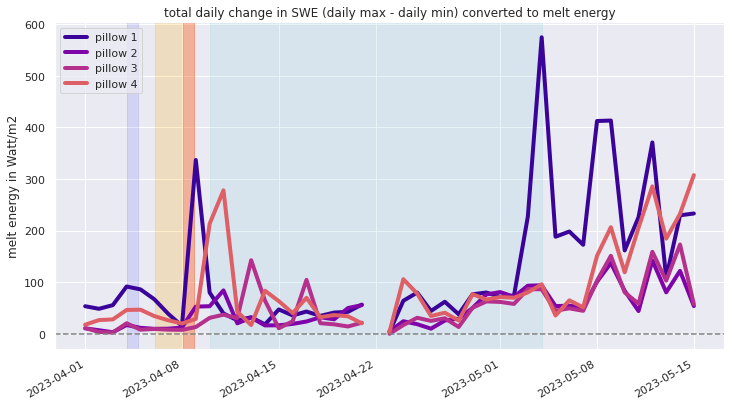

In [30]:
((ds.SWE_p1_c.resample(time='1D').max() - ds.SWE_p1_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000).plot(linewidth=4, label='pillow 1', color=colors1[1])
((ds.SWE_p2_c.resample(time='1D').max() - ds.SWE_p2_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000).plot(linewidth=4, label='pillow 2', color=colors1[3])
((ds.SWE_p3_c.resample(time='1D').max() - ds.SWE_p3_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000).plot(linewidth=4, label='pillow 3', color=colors1[5])
((ds.SWE_p4_c.resample(time='1D').max() - ds.SWE_p4_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000).plot(linewidth=4, label='pillow 4', color=colors1[7])

# plotting events
plt.axvspan(dt.datetime(2023,4,4,1), dt.datetime(2023,4,4,20), alpha=0.1, color='blue')     #snowfall event
plt.axvspan(dt.datetime(2023,4,6,1), dt.datetime(2023,4,8,20), alpha=0.2, color='orange')   #dust comes
plt.axvspan(dt.datetime(2023,4,8,1), dt.datetime(2023,4,8,20), alpha=0.2, color='red')      #dark dust (says notes)
plt.axvspan(dt.datetime(2023,4,10), dt.datetime(2023,5,4), alpha=0.3, color='lightblue')   #melt unset 

plt.title('total daily change in SWE (daily max - daily min) converted to melt energy')
plt.axhline(y = 0, color = 'grey', linestyle = '--')

plt.ylabel("melt energy in Watt/m2")
plt.xlabel("")
plt.legend(loc='upper left')
plt.show()

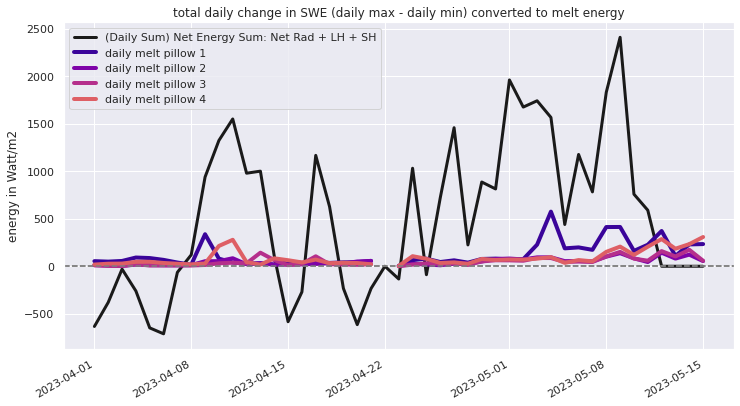

In [31]:
# cumulative sum energy 
# ds['Energy_sum'].plot(label='Net Energy Sum: Net Rad + LH + SH', linewidth=width, color='blue', alpha=.8)
ds_1D['Energy_sum'].plot(label='(Daily Sum) Net Energy Sum: Net Rad + LH + SH', linewidth=width, color='k')
# axes[0].set_ylim([-5000, 10000])
plt.axhline(y = 0, color = 'grey', linestyle = '--')

((ds.SWE_p1_c.resample(time='1D').max() - ds.SWE_p1_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000).plot(linewidth=4, label='daily melt pillow 1', color=colors1[1])
((ds.SWE_p2_c.resample(time='1D').max() - ds.SWE_p2_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000).plot(linewidth=4, label='daily melt pillow 2', color=colors1[3])
((ds.SWE_p3_c.resample(time='1D').max() - ds.SWE_p3_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000).plot(linewidth=4, label='daily melt pillow 3', color=colors1[5])
((ds.SWE_p4_c.resample(time='1D').max() - ds.SWE_p4_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000).plot(linewidth=4, label='daily melt pillow 4', color=colors1[7])

plt.title('total daily change in SWE (daily max - daily min) converted to melt energy')
plt.axhline(y = 0, color = 'grey', linestyle = '--')

plt.ylabel("energy in Watt/m2")
plt.xlabel("")
plt.legend(loc='upper left')
plt.show()

In [32]:
# daily melt energy for each of the snow pillows (above, but saving to a variable here)

melt_pillow1 = (ds.SWE_p1_c.resample(time='1D').max() - ds.SWE_p1_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000
melt_pillow2 = (ds.SWE_p2_c.resample(time='1D').max() - ds.SWE_p2_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000
melt_pillow3 = (ds.SWE_p3_c.resample(time='1D').max() - ds.SWE_p3_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000
melt_pillow4 = (ds.SWE_p4_c.resample(time='1D').max() - ds.SWE_p4_c.resample(time='1D').min()) * 334 * 1000 / 3600 / 24 * 1000 / 1000

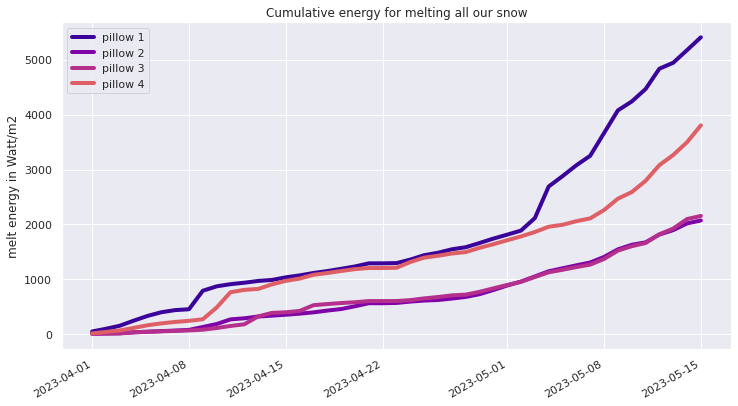

In [33]:
# daily melt energy for each of the snow pillows (above, but saving to a variable here)

melt_pillow1.cumsum().plot(linewidth=4, label='pillow 1', color=colors1[1])
melt_pillow2.cumsum().plot(linewidth=4, label='pillow 2', color=colors1[3])
melt_pillow3.cumsum().plot(linewidth=4, label='pillow 3', color=colors1[5])
melt_pillow4.cumsum().plot(linewidth=4, label='pillow 4', color=colors1[7])

plt.title('Cumulative energy for melting all our snow')

plt.ylabel("melt energy in Watt/m2")
plt.xlabel("")
plt.legend(loc='upper left')
plt.show()

*now, bringing in the calculated energy from the energy balance equations to compare with energy calculated from the snow pillows delta SWE*

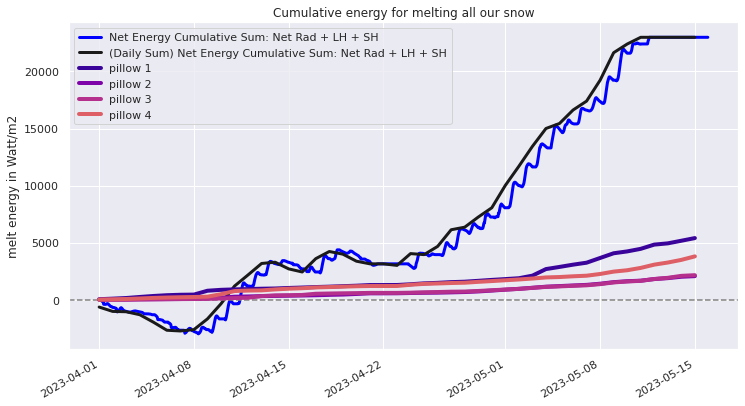

In [34]:
# cumulative sum energy 
ds['Energy_cumulative_sum'].plot(label='Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='blue')
ds_1D['Energy_cumulative_sum'].plot(label='(Daily Sum) Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='k')
# axes[0].set_ylim([-5000, 10000])
plt.axhline(y = 0, color = 'grey', linestyle = '--')

# daily melt energy for each of the snow pillows (above, but saving to a variable here)

melt_pillow1.cumsum().plot(linewidth=4, label='pillow 1', color=colors1[1])
melt_pillow2.cumsum().plot(linewidth=4, label='pillow 2', color=colors1[3])
melt_pillow3.cumsum().plot(linewidth=4, label='pillow 3', color=colors1[5])
melt_pillow4.cumsum().plot(linewidth=4, label='pillow 4', color=colors1[7])

plt.title('Cumulative energy for melting all our snow')

plt.ylabel("melt energy in Watt/m2")
plt.xlabel("")
plt.legend(loc='upper left')
plt.show()

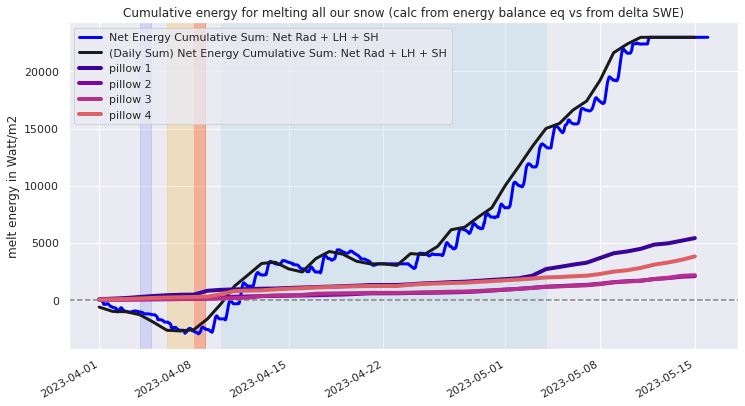

In [35]:
# cumulative sum energy 
ds['Energy_cumulative_sum'].plot(label='Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='blue')
ds_1D['Energy_cumulative_sum'].plot(label='(Daily Sum) Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='k')
# axes[0].set_ylim([-5000, 10000])
plt.axhline(y = 0, color = 'grey', linestyle = '--')

# plotting events
plt.axvspan(dt.datetime(2023,4,4,1), dt.datetime(2023,4,4,20), alpha=0.1, color='blue')     #snowfall event
plt.axvspan(dt.datetime(2023,4,6,1), dt.datetime(2023,4,8,20), alpha=0.2, color='orange')   #dust comes
plt.axvspan(dt.datetime(2023,4,8,1), dt.datetime(2023,4,8,20), alpha=0.2, color='red')      #dark dust (says notes)
plt.axvspan(dt.datetime(2023,4,10), dt.datetime(2023,5,4), alpha=0.3, color='lightblue')   #melt unset 

# daily melt energy for each of the snow pillows (above, but saving to a variable here)

melt_pillow1.cumsum().plot(linewidth=4, label='pillow 1', color=colors1[1])
melt_pillow2.cumsum().plot(linewidth=4, label='pillow 2', color=colors1[3])
melt_pillow3.cumsum().plot(linewidth=4, label='pillow 3', color=colors1[5])
melt_pillow4.cumsum().plot(linewidth=4, label='pillow 4', color=colors1[7])

plt.title('Cumulative energy for melting all our snow (calc from energy balance eq vs from delta SWE)')

plt.ylabel("melt energy in Watt/m2")
plt.xlabel("")
plt.legend(loc='upper left')
plt.show()

In [36]:
# okay.. taking a break on this for now and coming back to it.

# Don't forget I want to make calculations over two periods
#(dt.datetime(2023,4,1),  dt.datetime(2023,4,21)) # period 1 
#(dt.datetime(2023,4,25), dt.datetime(2023,5,10)) # period 2 

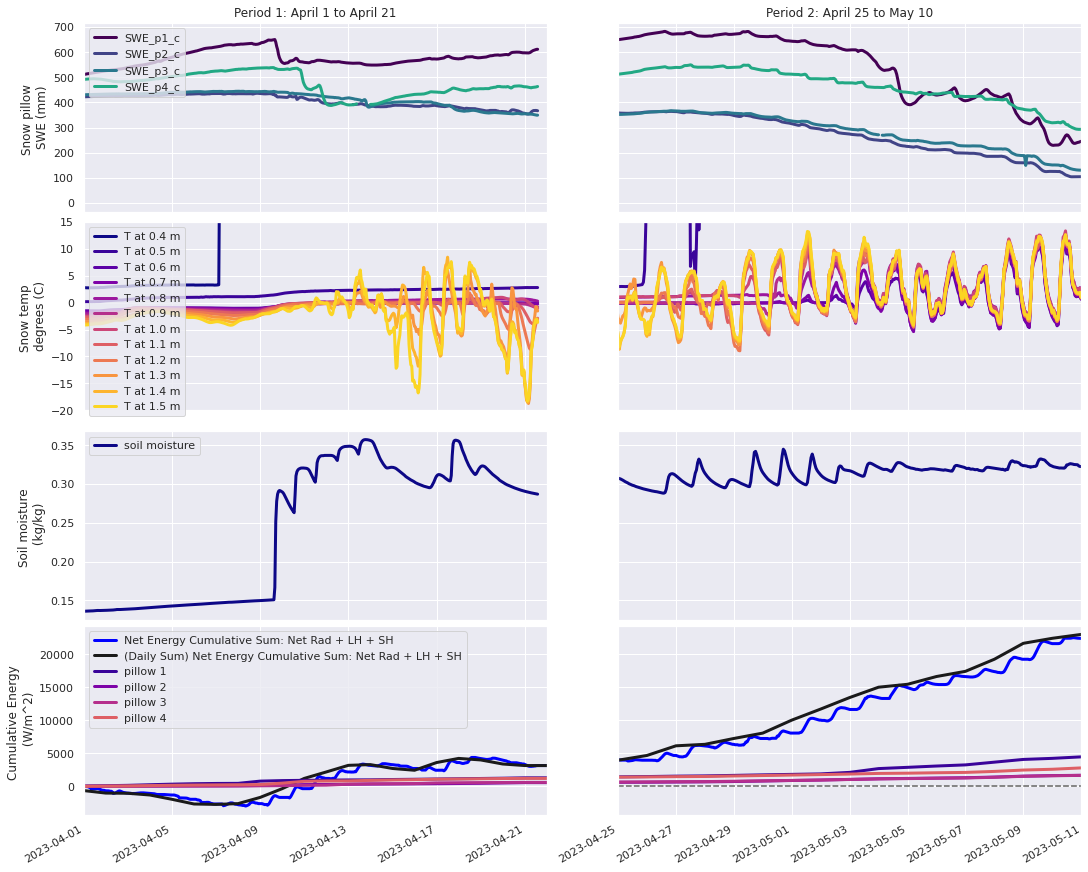

In [37]:
fig, axes = plt.subplots(4, 2, figsize=(15,12), sharex='col', sharey='row', constrained_layout = True, squeeze=True)

width = 3 # set most of the line widths here for visualization 
colors1 = plt.cm.plasma(np.linspace(0, 1, 13))
colors2 = plt.cm.viridis(np.linspace(0, 1, 6))

# column 1 ___________________________________________________________________________
ds['SWE_p1_c'].plot(ax=axes[0,0], label='SWE_p1_c', linewidth = width, color=colors2[0])
ds['SWE_p2_c'].plot(ax=axes[0,0], label='SWE_p2_c', linewidth = width, color=colors2[1])
ds['SWE_p3_c'].plot(ax=axes[0,0], label='SWE_p3_c', linewidth = width, color=colors2[2])
ds['SWE_p4_c'].plot(ax=axes[0,0], label='SWE_p4_c', linewidth = width, color=colors2[3])

ds['Tsnow_0_4m_d'].plot(ax=axes[1,0], label='T at 0.4 m', linewidth = width, color=colors1[0])
ds['Tsnow_0_5m_d'].plot(ax=axes[1,0], label='T at 0.5 m', linewidth = width, color=colors1[1])
ds['Tsnow_0_6m_d'].plot(ax=axes[1,0], label='T at 0.6 m', linewidth = width, color=colors1[2])
ds['Tsnow_0_7m_d'].plot(ax=axes[1,0], label='T at 0.7 m', linewidth = width, color=colors1[3])
ds['Tsnow_0_8m_d'].plot(ax=axes[1,0], label='T at 0.8 m', linewidth = width, color=colors1[4])
ds['Tsnow_0_9m_d'].plot(ax=axes[1,0], label='T at 0.9 m', linewidth = width, color=colors1[5])
ds['Tsnow_1_0m_d'].plot(ax=axes[1,0], label='T at 1.0 m', linewidth = width, color=colors1[6])
ds['Tsnow_1_1m_d'].plot(ax=axes[1,0], label='T at 1.1 m', linewidth = width, color=colors1[7])
ds['Tsnow_1_2m_d'].plot(ax=axes[1,0], label='T at 1.2 m', linewidth = width, color=colors1[8])
ds['Tsnow_1_3m_d'].plot(ax=axes[1,0], label='T at 1.3 m', linewidth = width, color=colors1[9])
ds['Tsnow_1_4m_d'].plot(ax=axes[1,0], label='T at 1.4 m', linewidth = width, color=colors1[10])
ds['Tsnow_1_5m_d'].plot(ax=axes[1,0], label='T at 1.5 m', linewidth = width, color=colors1[11])

# soil moisture
ds['Qsoil_d'].plot(ax=axes[2,0], label='soil moisture', linewidth = width, color=colors1[0])

# column 1 ___________________________________________________________________________
ds['SWE_p1_c'].plot(ax=axes[0,1], label='SWE_p1_c', linewidth = width, color=colors2[0])
ds['SWE_p2_c'].plot(ax=axes[0,1], label='SWE_p2_c', linewidth = width, color=colors2[1])
ds['SWE_p3_c'].plot(ax=axes[0,1], label='SWE_p3_c', linewidth = width, color=colors2[2])
ds['SWE_p4_c'].plot(ax=axes[0,1], label='SWE_p4_c', linewidth = width, color=colors2[3])

ds['Tsnow_0_4m_d'].plot(ax=axes[1,1], label='T at 0.4 m', linewidth = width, color=colors1[0])
ds['Tsnow_0_5m_d'].plot(ax=axes[1,1], label='T at 0.5 m', linewidth = width, color=colors1[1])
ds['Tsnow_0_6m_d'].plot(ax=axes[1,1], label='T at 0.6 m', linewidth = width, color=colors1[2])
ds['Tsnow_0_7m_d'].plot(ax=axes[1,1], label='T at 0.7 m', linewidth = width, color=colors1[3])
ds['Tsnow_0_8m_d'].plot(ax=axes[1,1], label='T at 0.8 m', linewidth = width, color=colors1[4])
ds['Tsnow_0_9m_d'].plot(ax=axes[1,1], label='T at 0.9 m', linewidth = width, color=colors1[5])
ds['Tsnow_1_0m_d'].plot(ax=axes[1,1], label='T at 1.0 m', linewidth = width, color=colors1[6])
ds['Tsnow_1_1m_d'].plot(ax=axes[1,1], label='T at 1.1 m', linewidth = width, color=colors1[7])
ds['Tsnow_1_2m_d'].plot(ax=axes[1,1], label='T at 1.2 m', linewidth = width, color=colors1[8])
ds['Tsnow_1_3m_d'].plot(ax=axes[1,1], label='T at 1.3 m', linewidth = width, color=colors1[9])
ds['Tsnow_1_4m_d'].plot(ax=axes[1,1], label='T at 1.4 m', linewidth = width, color=colors1[10])
ds['Tsnow_1_5m_d'].plot(ax=axes[1,1], label='T at 1.5 m', linewidth = width, color=colors1[11])

# soil moisture
ds['Qsoil_d'].plot(ax=axes[2,1], label='soil moisture', linewidth = width, color=colors1[0])

#_________________________________________________________________________________________
# cumulative sum energy 
ds['Energy_cumulative_sum'].plot(ax=axes[3,1],label='Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='blue')
ds_1D['Energy_cumulative_sum'].plot(ax=axes[3,1],label='(Daily Sum) Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='k')
axes[3,1].axhline(y = 0, color = 'grey', linestyle = '--')

# daily melt energy for each of the snow pillows (above, but saving to a variable here)
melt_pillow1.cumsum().plot(ax=axes[3,1], linewidth=width, label='pillow 1', color=colors1[1])
melt_pillow2.cumsum().plot(ax=axes[3,1], linewidth=width, label='pillow 2', color=colors1[3])
melt_pillow3.cumsum().plot(ax=axes[3,1], linewidth=width, label='pillow 3', color=colors1[5])
melt_pillow4.cumsum().plot(ax=axes[3,1], linewidth=width, label='pillow 4', color=colors1[7])

# cumulative sum energy 
ds['Energy_cumulative_sum'].plot(ax=axes[3,0],label='Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='blue')
ds_1D['Energy_cumulative_sum'].plot(ax=axes[3,0],label='(Daily Sum) Net Energy Cumulative Sum: Net Rad + LH + SH', linewidth=width, color='k')
axes[3,1].axhline(y = 0, color = 'grey', linestyle = '--')

# daily melt energy for each of the snow pillows (above, but saving to a variable here)
melt_pillow1.cumsum().plot(ax=axes[3,0], linewidth=width, label='pillow 1', color=colors1[1])
melt_pillow2.cumsum().plot(ax=axes[3,0], linewidth=width, label='pillow 2', color=colors1[3])
melt_pillow3.cumsum().plot(ax=axes[3,0], linewidth=width, label='pillow 3', color=colors1[5])
melt_pillow4.cumsum().plot(ax=axes[3,0], linewidth=width, label='pillow 4', color=colors1[7])


# legends et al. ___________________________________________________________________________
axes[0,0].legend(loc='upper left')
axes[1,0].legend(loc='upper left')
axes[2,0].legend(loc='upper left')
axes[3,0].legend(loc='upper left')

axes[0,0].set_xlabel("")
axes[1,0].set_xlabel("")
axes[2,0].set_xlabel("")
axes[3,0].set_xlabel("")

axes[0,1].set_xlabel("")
axes[1,1].set_xlabel("")
axes[2,1].set_xlabel("")
axes[3,1].set_xlabel("")

axes[0,0].set_title("Period 1: April 1 to April 21")
axes[0,1].set_title("Period 2: April 25 to May 10")

axes[0,0].set_ylabel("Snow pillow \nSWE (mm)")
axes[1,0].set_ylabel("Snow temp \ndegrees (C)")
axes[2,0].set_ylabel("Soil moisture \n (kg/kg)")
# axes[3,0].set_ylabel("Cumulative sum \n Combined flux (W/m^2*hr)")
axes[3,0].set_ylabel("Cumulative Energy \n (W/m^2)")

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")
axes[2,1].set_ylabel("")
axes[3,1].set_ylabel("")

axes[1,0].set_ylim([-20,15]);axes[1,1].set_ylim([-20,15])

axes[0,0].set_xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,22))  # time period 1
axes[0,1].set_xlim(dt.datetime(2023,4,25), dt.datetime(2023,5,11)) # time period 2

plt.show()

In [38]:
pillow_melt_energy_mean = (melt_pillow1.mean() + melt_pillow2.mean() + melt_pillow3.mean() + melt_pillow4.mean()) / 4 
met_met_energy_mean = ds_1D['Energy_sum'].mean()

In [39]:
print('Melt Energy Mean from all pillows: ', pillow_melt_energy_mean)
print('Mean Energy Balance from met data: ', met_met_energy_mean)

Melt Energy Mean from all pillows:  <xarray.DataArray ()>
array(76.37022121)
Mean Energy Balance from met data:  <xarray.DataArray 'Energy_sum' ()>
array(510.77228719)


--- 
### Problem 1: Part D Solution. 
**d) the total daily snow melt for the period from April 1 to April 21, and then, separately from April 25 to May 10.**  

* Do our data suggest that the mass and energy budgets work? 
    * Well, if I had more time I would plot some 1 to 1 plots, or look at this more to see if I made a mistake, but for now, I do not think our mass/energy balance budgets work out. I have more energy being calculated from the energy balance equation than from delta SWE of melt energy. The average for all the pillows is 76.3 W/m2 day and the average for the met data energy balance is 510.7 W/m2 day. So the energy balance is off by a factor of 10. This makes me think I made a mistake somewhere... 
    
At the start of the assignment we calculated the total energy balance as, 

$$
c_p^{SS} \frac{\delta T_{SS}}{\delta t} + \lambda \frac{\delta T_{S}}{\delta z} + E_{melt} = LW_{in} - LW_{out} + SW_{in} - SW_{out} - LH - SH + G 
$$

where $ E_{melt} $ is calculated using $ \delta SWE $ from the snow pillows compared to the energy balance from the met data calculated on the right side of the equation. 

* (If we assume my calculations don't have a mistake... they prob do but) Some sources of error could include not considering the ground heat flux, or just general errors in met data measurements. We also assume that all the energy (left hand side of the equation) is going into melting the snow because the snowpack is isothermal. However, the snow temperatures show some temperature gradient through the snowpack up until April 10th so that's not a great assumption to make until April 10th. There could be some errors with radiation measurements.. but 10% seems like a big enough error that something big is missing in the energy balance calculations. 


---

In [40]:
## If I have time, I'll come back to problem 1 to continue probelm solving my 10% difference in the energy balance. 

---

## Problem 2: Feedback on class modules
To give you time to work on your final class project, instead of more analysis, just write a few sentences about which of the course labs and/or homeworks were the most challenging/frustrating and which extra help/examples/code/time/etc would help make them more accessible. Thank you!

---

---
* For reference, each assignment took me anywhere between 4 and 6 hours. It took typically took an hour or two just to figure out what data I needed and to get everything put together in a tidy way to work with it. 
* I'm sure that the turbulence assignment was the hardest. I started it but then decided just to skip it because I was far too busy to take an entire day to figure it out. I do think the end of the quarter is a rough time for that depth of an assignment (and it's too easy to just decide to drop it at that point when we have a drop.. haha)
* As a general statement, I think going to the maker space was cool to check it out, but I think we lost a lot of time there and made the class feel more disjointed going so early in the quarter (combined with field trip)

#### Other Comments. 
This is not related to a specific homework/lab, but just when the quarter started I was feeling challenged at first understanding the data streams + sources + timezones + sensors, etc. 
* As time went on, I could figure out where variables were and what time zone I was in, and what data I should be looking at, but during the first three assignments I think I asked Danny 12 times per assignment what sensors this is, where the flow caps are, why is it randsys and not sos? what units is this? what time zone is this? is there daylight savings? etc. 
    * Most simply, this could be improved by providing a mean NetCDF with *ONLY* the data needed for the assignment for the first and second assignments. Just to get us started without overwhelm. 
    * I also think this could be improved early in the class by having a diagram drawn out (similar to Lab 2: Mass balance pillows diagram on the website) explaining all the different instruments and datasources that we are going to use in *each* assignment, and where they are in spatial location to eachother. That's very helpful!  
    * I know we discuss this in class for a slide or two, but I think the simple and most important information related to the sensors we are using should be shown (again) on the page with the homework assignment. 
    
A specific example for my suggesion, 
* For HW4: Wind speed and Particle Flux. 
    * At this point, we had to pull in another data stream (FlowCap sensors from radsys). I was super confused about this. I did not know what the sensor was, what it was measuring, etc. I was struggling to understand how the units related to other sensors.. it was just confusing to have data coming at me from different directions. So I think it would have been helpful to see a diagram on the github page of the flow cap sensors, and where they are in the plots compared to the wind speed towers, etc. 

--- 